In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
import time
register_matplotlib_converters()
%matplotlib inline
from datetime import date
from datetime import datetime

In [52]:
### Import insolation data (individual sensors and global)

# data from individual sensors (Apogee SP110)
insol = pd.read_csv("insolation_data/Rooftop_2019_insolation.csv",
                   encoding = "mbcs", # for ANSI  encoding
                   sep = ";", # specify seperator 
                   index_col = "TIMESTAMP",parse_dates=True,dayfirst=True) # choosing index column

# data from high precission global sensors (Ph. Schenk, Type 8102)
glob = pd.read_csv("insolation_data/Rooftop_2019_global_10min.csv",
                   encoding = "mbcs", # for ANSI  encoding
                   sep = ";", # specify seperator 
                  ) # without defining an index column

In [53]:
glob.index = pd.to_datetime(glob["datesec"], unit='s') # define index; convert unix epoch time to datetime
glob.index.rename("TIMESTAMP",inplace=True) # rename index

In [54]:
### reindexing with time zone aware indexes, to convert between GMT0 and GMT2.
glob_tz = glob.tz_localize("GMT-0",copy = False)        #localise the timezone
glob_tz.index = glob_tz.index.tz_convert("Etc/GMT-2")   #then convert to time zone of choice

insol_tz = insol.tz_localize("Etc/GMT-2",copy = False)  #localise own data

In [55]:
## calculate hourly mean; label each bin using the right edge instead of the left
glob_res_mean = glob_tz.glow.resample('1H', label = 'right').mean()
glob_res_std = glob_tz.glow.resample('1H', label = 'right').std()

## create new column in glob_tz 
glob_tz['glob_res_mean'] = glob_res_mean
glob_tz['glob_res_std'] = glob_res_std

##create new dataframe where lines with nan are dropped
glob_tz_clean = glob_tz.dropna()

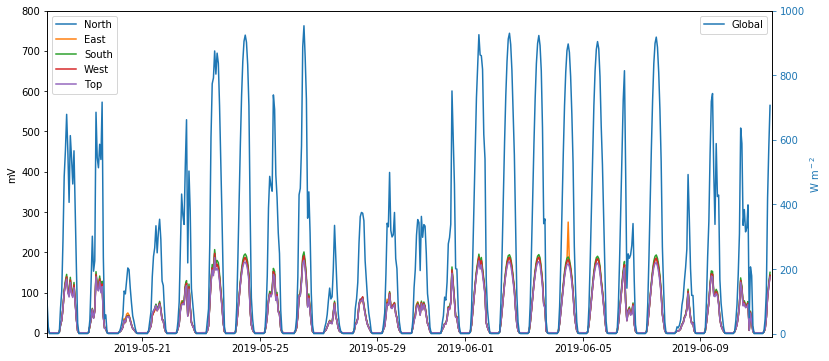

In [56]:
## plot of entire calibration period (before start of the experiment)
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""
start = "2019-05-17 18:00:00"
end   = "2019-06-11 11:00:00"

fig,ax = plt.subplots(figsize = (13, 6))

ax.plot(insol_tz["N_mV_AVG"][start:end], label = "North")
ax.plot(insol_tz["E_mV_AVG"][start:end], label = "East")
ax.plot(insol_tz["S_mV_AVG"][start:end], label = "South")
ax.plot(insol_tz["W_mV_AVG"][start:end], label = "West")
ax.plot(insol_tz["TOP_mV_AVG"][start:end], label = "Top")
ax.set_ylabel('mV')
ax.legend(loc = 'upper left')

ax1 = ax.twinx()
ax1.plot(glob_tz_clean["glob_res_mean"][start:end], label = "Global")
ax1.set_ylabel('W m$^-$$^2$')
ax1.yaxis.label.set_color(color="tab:blue")
ax1.tick_params(axis='y', colors='tab:blue')
ax1.legend(loc='upper right')

ax.set_xlim(start, end)
ax.set_ylim(-10, 800)
ax1.set_ylim(-10, 1000)

plt.show()

In [57]:
## calculate simple calibration factors for each sensors by dividing global signal [W/m^2] with inidvidual signal (mV)
cal_N   = glob_tz_clean["glob_res_mean"]/insol_tz["N_mV_AVG"]
cal_E   = glob_tz_clean["glob_res_mean"]/insol_tz["E_mV_AVG"]
cal_S   = glob_tz_clean["glob_res_mean"]/insol_tz["S_mV_AVG"]
cal_W   = glob_tz_clean["glob_res_mean"]/insol_tz["W_mV_AVG"]
cal_TOP = glob_tz_clean["glob_res_mean"]/insol_tz["TOP_mV_AVG"]

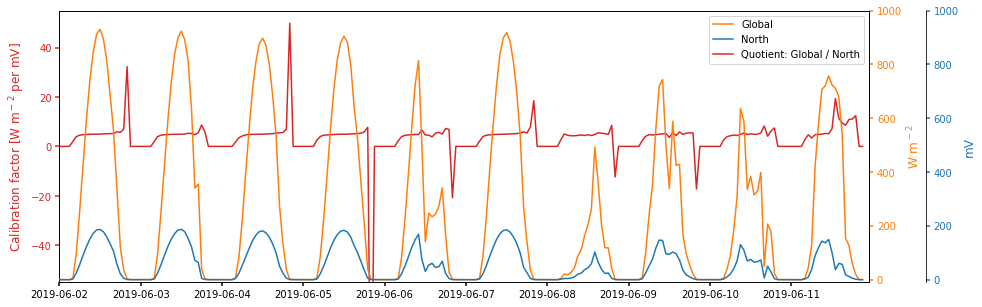

In [58]:
## plot a any individual sensor against global sensor 
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""

start = "2019-06-02 00:00:00"
end   = "2019-06-11 23:00:00"

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize = (18, 5))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.07))
# Having been created by twinx, par2 has its frame off, so the line of its detached spine is invisible.  First, activate the frame but make the patch and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(cal_N[start:end], label = "Quotient: Global / North", color="tab:red")
p2, = par1.plot(glob_tz_clean["glob_res_mean"][start:end], label = "Global", color="tab:orange")
p3, = par2.plot(insol_tz["N_mV_AVG"][start:end], label = "North", color="tab:blue")

host.set_xlim(start, end)
host.set_ylim(-55, 55)
par1.set_ylim(-10, 1000)
par2.set_ylim(-10, 1000)

host.set_ylabel("Calibration factor [W m$^-$$^2$ per mV]", fontsize = "large")
par1.set_ylabel("W m$^-$$^2$", fontsize = "large")
par2.set_ylabel("mV",  fontsize = "large")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p2, p3, p1]

host.legend(lines, [l.get_label() for l in lines])
plt.savefig('individual sensor against global sensor.png', dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.2)
plt.show()

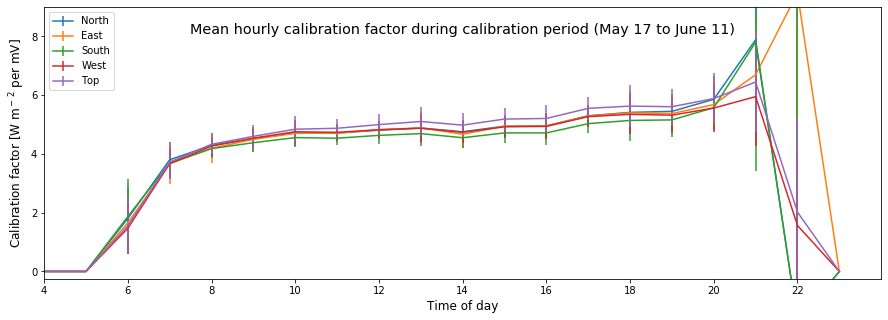

In [59]:
## plot the mean dayly course of the calibration factor during calibration period
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""
start = "2019-05-17 18:00:00"
end   = "2019-06-11 11:00:00"

fig,ax = plt.subplots(figsize = (15, 5))
qN   = glob_tz_clean['glob_res_mean'][start:end]/insol_tz["N_mV_AVG"][start:end]
qS   = glob_tz_clean['glob_res_mean'][start:end]/insol_tz["S_mV_AVG"][start:end]
qE   = glob_tz_clean['glob_res_mean'][start:end]/insol_tz["E_mV_AVG"][start:end]
qW   = glob_tz_clean['glob_res_mean'][start:end]/insol_tz["W_mV_AVG"][start:end]
qTOP = glob_tz_clean['glob_res_mean'][start:end]/insol_tz["TOP_mV_AVG"][start:end]

xi = qN.groupby(qN.index.hour).mean().index

ax.errorbar(x=xi,y=qN.groupby(qN.index.hour).mean(),yerr=qN.groupby(qN.index.hour).std(),label = "North")
ax.errorbar(x=xi,y=qE.groupby(qE.index.hour).mean(),yerr=qE.groupby(qE.index.hour).std(),label = "East")
ax.errorbar(x=xi,y=qS.groupby(qS.index.hour).mean(),yerr=qS.groupby(qS.index.hour).std(),label = "South")
ax.errorbar(x=xi,y=qW.groupby(qW.index.hour).mean(),yerr=qW.groupby(qW.index.hour).std(),label = "West")
ax.errorbar(x=xi,y=qTOP.groupby(qTOP.index.hour).mean(),yerr=qTOP.groupby(qTOP.index.hour).std(),label = "Top")

start1 = datetime.strptime(start, "%Y-%m-%d %H:%M:%S") # print(start1.strftime("%B"), start1.day) 
end1   = datetime.strptime(end, "%Y-%m-%d %H:%M:%S") 

ax.legend()
#ax.set_title('Mean hourly calibration factor during calibration period ({} {} to {} {})'.format(start1.strftime("%B"), start1.day, end1.strftime("%B"), end1.day),fontsize = "x-large")
ax.text(.5,.9,'Mean hourly calibration factor during calibration period ({} {} to {} {})'.format(start1.strftime("%B"), start1.day, end1.strftime("%B"), end1.day),fontsize = "x-large",
        horizontalalignment='center',
        transform=ax.transAxes)

ax.set_ylabel('Calibration factor [W m$^-$$^2$ per mV]', fontsize = "large")
ax.set_xlabel('Time of day',fontsize = "large")




ax.set_xlim(4,24)
ax.set_ylim(-0.25,9)
plt.xticks(np.arange(4, 24, 2))
plt.savefig('Mean hourly calibratin factor.png', dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.2)
plt.show()

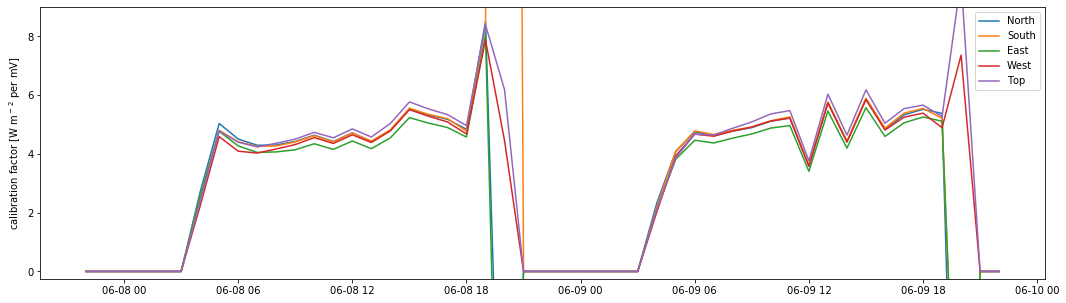

In [60]:
## plot all individual calibration factors for given date (before zenith correction)
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""
start = "2019-06-08 00:00:00"
end   = "2019-06-10 00:00:00"

fig,ax = plt.subplots(figsize = (18, 5))

ax.plot(cal_N[start:end],   label = "North")
ax.plot(cal_E[start:end],   label = "South")
ax.plot(cal_S[start:end],   label = "East")
ax.plot(cal_W[start:end],   label = "West")
ax.plot(cal_TOP[start:end], label = "Top")

#ax.set_ylim([2,7])
ax.set_ylim(-0.25, 9)
ax.legend()
ax.set_ylabel('calibration factor [W m$^-$$^2$ per mV]')
plt.show()

### Zenith angles and filtering disturbing values

In [61]:
import math
from datetime import date
from datetime import datetime

# by default when reading a csv or excel file into a dataframe and setting 'Parse Dates' to true
# the Datetime index contains datetime64 objects rather than datetime objects...
# we can call 'year', 'month', 'day' and 'hour' on a datetime object!!

def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((date - np.datetime64('1970-01-01 00:00:00+02:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

# defining the ZenithAngle getter function, which takes in a datetime argument

def getZenithAngle(datetime,latitude=47.264253):
    H      = datetime.hour
    lat    = math.radians(latitude)
    d      = datetime.day
    m      = datetime.month
    sw     = math.radians((H-12)*15)
    f_date = date(2019, 1, 1)
    l_date = date(2019, m, d)
    delta  = l_date - f_date

    dec    = math.radians(23.43*math.sin(math.radians(360*(284+delta.days)/365)))
    sinusH = math.cos(dec)*math.cos(sw)*math.cos(lat)+math.sin(dec)*math.sin(lat)
    H      = math.degrees(math.asin(sinusH))

    return H

In [62]:
def addZenithAngle(series):
    series = pd.DataFrame(series)
    series["zenith_angle"] = [getZenithAngle(to_datetime(series.index.values[k])) for k in range(0,len(series))]
    return series
    
cal_N   = addZenithAngle(cal_N)
cal_S   = addZenithAngle(cal_S)
cal_E   = addZenithAngle(cal_E)
cal_W   = addZenithAngle(cal_W)
cal_TOP = addZenithAngle(cal_TOP)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [63]:
# create a column called "HoD" (hour of day) in insolation dataframe
insol_tz["HoD"] = [to_datetime(insol_tz.index.values[k]).hour for k in range(0,len(insol_tz))]
# create a column called ZA in insolation dataframe
insol_tz["ZA"]=[getZenithAngle(to_datetime(insol_tz.index.values[k])) for k in range(0,len(insol_tz))]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [64]:
# Filter out zenith angle values lower than critical algle (15 degrees)
cal_N_Zen   = cal_N.dropna().query("zenith_angle > 15")
cal_S_Zen   = cal_S.dropna().query("zenith_angle > 15")
cal_E_Zen   = cal_E.dropna().query("zenith_angle > 15")
cal_W_Zen   = cal_W.dropna().query("zenith_angle > 15")
cal_TOP_Zen = cal_TOP.dropna().query("zenith_angle > 15")

In [65]:
# replace calibration factor by zero wherever zenith angle is negative
cal_N.loc[cal_N["zenith_angle"]<= 0 , 0 ] = 0

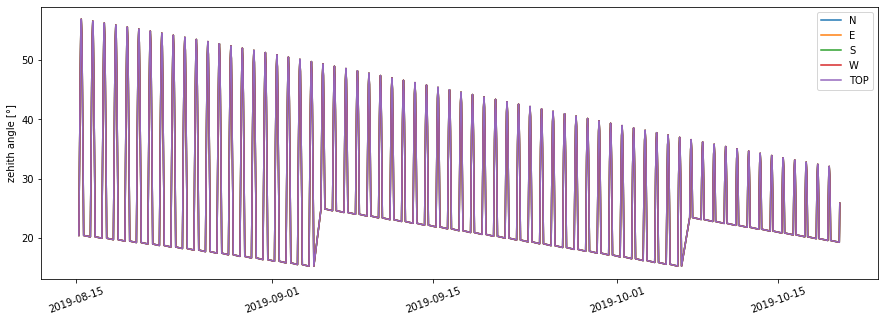

In [66]:
## TEST: plot zenith angle after cutoff
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""
start = "2019-08-14 18:00:00"
end   = "2019-10-20 10:00:00"

fig,ax = plt.subplots(figsize = (15,5))

ax.plot(cal_N_Zen["zenith_angle"][start:end],   label = "N")
ax.plot(cal_E_Zen["zenith_angle"][start:end],   label = "E")
ax.plot(cal_S_Zen["zenith_angle"][start:end],   label = "S")
ax.plot(cal_W_Zen["zenith_angle"][start:end],   label = "W")
ax.plot(cal_TOP_Zen["zenith_angle"][start:end], label = "TOP")

ax.set_ylabel('zehith angle [°]')
plt.xticks(rotation=20)
ax.legend()
plt.show()

In [67]:
# Calibration period 1 (before the start of the experiment)
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""
start = "2019-05-17 15:00:00"
end   = "2019-06-11 11:00:00"

# Grouping and averaging by hourly values to get hour specific calibration factors

cal_N1_Zen   = cal_N_Zen[start:end].groupby(cal_N_Zen[start:end].index.hour).mean()[0]
cal_E1_Zen   = cal_E_Zen[start:end].groupby(cal_E_Zen[start:end].index.hour).mean()[0]
cal_S1_Zen   = cal_S_Zen[start:end].groupby(cal_S_Zen[start:end].index.hour).mean()[0]
cal_W1_Zen   = cal_W_Zen[start:end].groupby(cal_W_Zen[start:end].index.hour).mean()[0]
cal_TOP1_Zen = cal_TOP_Zen[start:end].groupby(cal_TOP_Zen[start:end].index.hour).mean()[0]


hour_factors = {"N":cal_N1_Zen,
               "S":cal_S1_Zen,
               "E":cal_E1_Zen,
               "W":cal_W1_Zen,
               "TOP":cal_TOP1_Zen} 


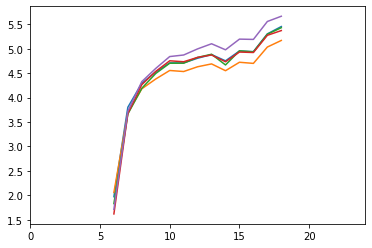

In [68]:
fig,ax = plt.subplots()

for i in hour_factors:
    ax.plot(hour_factors[i])
    
ax.set_xlim(0,24)

plt.show()

In [69]:
# Calibration period 1 (before the start of the experiment)
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""
start = "2019-05-17 15:00:00"
end   = "2019-06-11 11:00:00"

# Grouping and averaging by hourly values to get hour specific calibration factors

cal_N1   = cal_N[start:end].groupby(cal_N[start:end].index.hour).mean()
cal_E1   = cal_E[start:end].groupby(cal_E[start:end].index.hour).mean()
cal_S1   = cal_S[start:end].groupby(cal_S[start:end].index.hour).mean()
cal_W1   = cal_W[start:end].groupby(cal_W[start:end].index.hour).mean()
cal_TOP1 = cal_TOP[start:end].groupby(cal_TOP[start:end].index.hour).mean()

hour_factors_nofilter= {"N":cal_N1,
               "S":cal_S1,
               "E":cal_E1,
               "W":cal_W1,
               "TOP":cal_TOP1}  

In [70]:
# Get hourly calibration factor depending on the time of day (HoD) and the sensor used (orientation) and the zenith

def getFactor(orientation, HoD,ZA):
    if ZA <= 0:
            return 0
    elif (HoD in hour_factors[orientation])== True:
        return hour_factors[orientation][HoD]
    else:
        return hour_factors[orientation].mean()

In [71]:
# Where everything is now happening: calibrating by orientation and time of day

for ori in ("N","E","S","W","TOP"):
    list1 = [i*getFactor(ori,j,k) for i,j,k in zip(insol_tz["{}_mV_AVG".format(ori)],insol_tz["HoD"],insol_tz["ZA"])]
    list2 = [getFactor(ori,j,k) for j,k in zip(insol_tz["HoD"],insol_tz["ZA"])]

    insol_tz["{}_Insol_Wm-2".format(ori)] = [0 if i < 0 else i for i in list1]
    insol_tz["{}_calfac".format(ori)] = list2



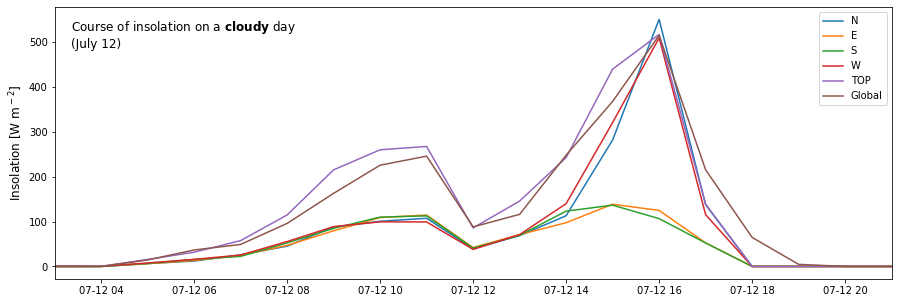

In [72]:
# plot of calibration period (after calibration with glob sensor)
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""

start = "2019-07-12 00:00:00"
end   = "2019-07-13 00:00:00"

fig,ax = plt.subplots(figsize = (15,5))

for ori in ("N","E","S","W","TOP"):
    ax.plot(insol_tz["{}_Insol_Wm-2".format(ori)][start:end], label = ori)
ax.plot(glob_tz_clean["glob_res_mean"][start:end], label = "Global")


ax.set_ylabel('Insolation [W m$^-$$^2$]', fontsize = "large")
ax.set_xlim(["2019-07-12 03:00:00","2019-07-12 21:00:00"])
ax.legend()
ax.text(0.02,.85,'Course of insolation on a ' + r"$\bf{" + "cloudy" + "}$" + ' day \n(July 12)',fontsize = "large",
        horizontalalignment='left',
        transform=ax.transAxes)
#plt.savefig('insolation_dayly_course_cloudy_2.png', dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.2)
plt.show() 



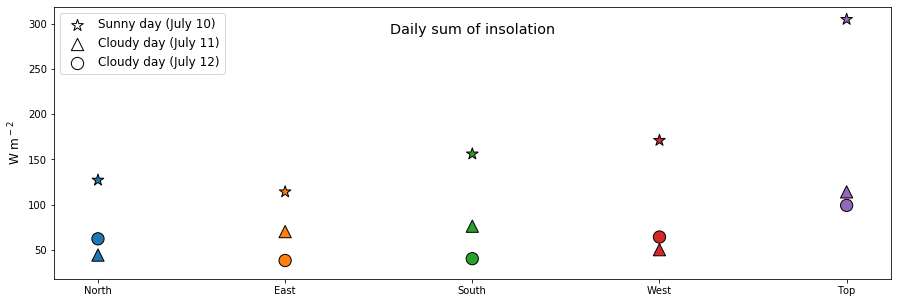

In [73]:
fig,ax = plt.subplots(figsize = (15,5))

ax.text(0.5,.9,'Daily sum of insolation',fontsize = "x-large",
        horizontalalignment='center',
        transform=ax.transAxes)


plt.scatter(["North","East","South","West", "Top"],[127, 114,156, 171, 305],
            color=['tab:blue','tab:orange','tab:green', 'tab:red', 'tab:purple'], 
            marker = '*', s = 150, edgecolor= 'k', linewidth = 1, label = "Sunny day (July 10)")
plt.scatter(["North","East","South","West", "Top"],[44,70,76,50, 114],
            color=['tab:blue','tab:orange','tab:green', 'tab:red', 'tab:purple'], 
           marker = '^',s = 150, edgecolor= 'k', linewidth = 1, label = "Cloudy day (July 11)")
plt.scatter(["North","East","South","West", "Top"],[62,38,40,64, 99],
            color=['tab:blue','tab:orange','tab:green', 'tab:red', 'tab:purple'], 
           marker = 'o',s = 150, edgecolor= 'k', linewidth = 1, label = "Cloudy day (July 12)")

plt.ylabel('W m$^-$$^2$', fontsize = "large")

leg = leg = plt.legend(fontsize = "large")
LH = leg.legendHandles
LH[0].set_linewidth(1)
LH[1].set_linewidth(1) 
LH[2].set_linewidth(1) 
LH[0].set_color('w')
LH[0].set_edgecolor('k')
LH[1].set_color('w')
LH[1].set_edgecolor('k')
LH[2].set_color('w')
LH[2].set_edgecolor('k')

#plt.savefig('insolation_comparison_sunny_cloudy.png', dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.2)
plt.show()

## Calculating the total insolation over the measurement period

In [74]:
""" 
calibration period 1:             duration of the experiment:       calibration period 2: 
start = "2019-05-17 18:00:00"     start = "2019-06-11 16:00:00"     start = "2019-10-25 18:00:00"
end   = "2019-06-11 11:00:00"     end   = "2019-10-25 15:00:00"     end   = "2019-10-31 10:00:00"
"""

start = "2019-06-11 16:00:00"
end   = "2019-10-25 15:00:00"

np.timedelta64((insol_tz[start:end].index.values[-1]-insol_tz[start:end].index.values[0]),'h')

for ori in ("N","E","S","W","TOP"):
    print("Sensor {}: {:.2f} kW m-2".format(ori,insol_tz[start:end]["{}_Insol_Wm-2".format(ori)].sum()/1000))

Sensor N: 205.78 kW m-2
Sensor E: 205.02 kW m-2
Sensor S: 331.31 kW m-2
Sensor W: 397.34 kW m-2
Sensor TOP: 579.93 kW m-2
